In [1]:
from itertools import chain

In [2]:
import numpy as np

np.random.seed(2020)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0.1

# Data

In [4]:
def m(x):
    return np.cos(x) + 0.5 * x

def e(x):
    return 0.5 * np.exp(0.3 * x)

In [5]:
x_min, x_max = -6, 6
x_lin = np.linspace(x_min, x_max, 500)
m_lin = m(x_lin)
e_lin = e(x_lin)

In [6]:
def length_to_range(lengths: [int]):
    lengths = [0] + np.cumsum(lengths).tolist()
    return [range(a, b) for a, b in zip(lengths[:-1], lengths[1:])]

In [7]:
# random sets of varying lengths
lengths = np.random.randint(2, 5, (100,))
indices = list(map(list, length_to_range(lengths)))

In [8]:
# heteroscedastic gaussian noise
n = sum(lengths)
x = np.random.uniform(x_min, x_max, n)
z = m(x) + e(x) * np.random.randn(n)

In [9]:
# mean observation
y = np.array([z[idx].mean() for idx in indices])

In [10]:
def plot_mean(ax, x, z, c):
    ax.axhline(z.mean(), color=c)
    ax.scatter(x, z, color=c)
    for xi, zi in zip(x, z):
        ax.vlines(xi, z.mean(), zi, color=c)

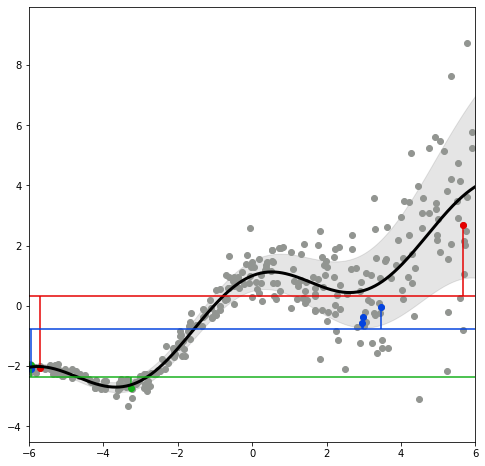

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(x_lin, m_lin, color='k', linewidth=3)
ax.fill_between(x_lin, m_lin + e_lin, m_lin - e_lin, color='k', alpha=0.1)
ax.scatter(x, z, color='xkcd:gray', alpha=1)

plot_mean(ax, x[indices[0]], z[indices[0]], 'xkcd:red')
plot_mean(ax, x[indices[1]], z[indices[1]], 'xkcd:green')
plot_mean(ax, x[indices[2]], z[indices[2]], 'xkcd:blue')

# MLP

In [12]:
import torch
import torch.nn.functional as F
from torch import nn, optim

torch.manual_seed(2020);

In [13]:
from tqdm import trange

In [14]:
# tensors
x_tr = torch.tensor(x[:, None]).float()
y_tr = torch.tensor(y[:, None]).float()
x_ts = torch.tensor(x_lin[:, None]).float()

In [15]:
def get_model(dim_output=1):
    return nn.Sequential(
        nn.Linear(1, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, dim_output),
    )

In [16]:
def homo_gaussian_loss(t, y, l):
    ranges = length_to_range(l)
    m = torch.stack([t[r, 0].mean() for r in ranges])
    return F.mse_loss(m[:, None], y)

In [17]:
def hetro_gaussian_loss(t, y, l):
    ranges = length_to_range(l)
    mean = t[:, 0]
    var = torch.exp(t[:, 1])
    m = torch.stack([mean[r].mean() for r in ranges])
    v = torch.stack([var[r].sum() / (len(r) ** 2) for r in ranges])
    return (((m - y.view(-1)) ** 2 / v) + torch.log(v)).mean()

In [18]:
batch_size = 32

def train(model, optimizer, loss):
    # indices
    idx_batch = np.random.choice(len(indices), size=batch_size)
    idx_data = list(chain(*[indices[idx_y] for idx_y in idx_batch]))
    
    # batch
    x_batch = x_tr[idx_data]
    y_batch = y_tr[idx_batch]
    l_batch = lengths[idx_batch]

    # optimization
    optimizer.zero_grad()
    loss(model(x_batch), y_batch, l_batch).backward()
    optimizer.step()

In [19]:
num_iters = 500

In [20]:
model = get_model(dim_output=1)
optimizer = optim.Adam(model.parameters())

# train
for _ in trange(num_iters):
    train(model, optimizer, homo_gaussian_loss)

# test
with torch.no_grad():
    mean_1 = model(x_ts).numpy().ravel()

100%|██████████| 500/500 [00:02<00:00, 185.62it/s]


In [21]:
model = get_model(dim_output=2)
optimizer = optim.Adam(model.parameters())

# train
for _ in trange(num_iters):
    train(model, optimizer, hetro_gaussian_loss)

# test
with torch.no_grad():
    mean_2, logvar = model(x_ts).numpy().T
    std_2 = np.sqrt(np.exp(logvar))

100%|██████████| 500/500 [00:03<00:00, 137.63it/s]


# GBM

In [22]:
import lightgbm as lgb

In [23]:
def aggregate_obj(grad_hess_func):
    def obj(preds: np.ndarray, train_data: lgb.Dataset) -> (np.ndarray, np.ndarray):
        label = train_data.get_label()
        group = train_data.get_group()

        grad = np.zeros(len(preds))
        hess = np.zeros(len(preds))

        head, last = 0, 0
        for num_i in group.astype(int):
            head, last = last, last + num_i

            preds_i = preds[head:last]
            label_i = label[head:last]

            grad_i, hess_i = grad_hess_func(preds_i, label_i)

            grad[head:last] = grad_i
            hess[head:last] = hess_i

        return grad, hess
    
    return obj

In [24]:
def grad_hess_mean_gaussian(preds: np.ndarray, label: np.ndarray):
    k = preds.shape[0]
    y = label[0]
    grad = np.ones(k) / k * (preds.mean() - y)
    hess = np.ones(k) / k ** 2
    return grad, hess

In [25]:
lgb_tr = lgb.Dataset(x[:, None], list(chain(*[[yi] * li for yi, li in zip(y, lengths)])), group=lengths)
lgb_vl = lgb_tr

params = {
    'boosting_type': 'gbdt',
    'verbose': -1,
}

gbm = lgb.train(
    params,
    lgb_tr,
    num_boost_round=50,
    valid_sets=lgb_vl,
    fobj=aggregate_obj(grad_hess_mean_gaussian),
    verbose_eval=False,
)

mean_3 = gbm.predict(x_lin[:, None])

# Result

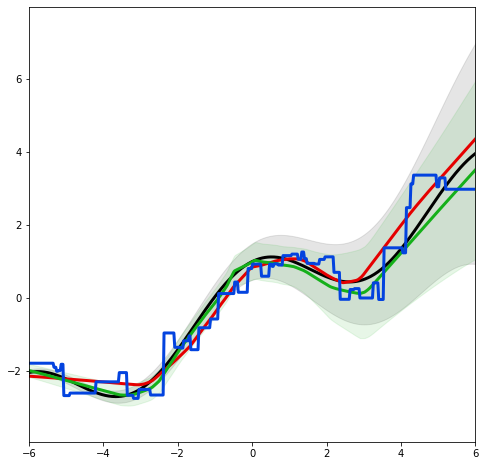

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(x_lin, m_lin, color='k', linewidth=3)
ax.fill_between(x_lin, m_lin + e_lin, m_lin - e_lin, color='k', alpha=0.1)

ax.plot(x_lin, mean_1, color='xkcd:red', linewidth=3)

ax.plot(x_lin, mean_2, color='xkcd:green', linewidth=3)
ax.fill_between(x_lin, mean_2 + std_2, mean_2 - std_2, color='xkcd:green', alpha=0.1)

ax.plot(x_lin, mean_3, color='xkcd:blue', linewidth=3);